### BigData & Blockchain Lab
#### BTC-USD Price Prediction as Binary Classification problem(Buy/Sell) with Deep LSTM NN.
#### import pa for technical indicators

#### Presented by @SAnbaee

In [1]:
import tensorflow as tf
import pandas as pd
from collections import deque
import random
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, LSTM, BatchNormalization
from matplotlib import pyplot as plt
import ta
from matplotlib import pyplot as plt


In [17]:

SEQ_LEN = 7 # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1 # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "BTC-USD"
EPOCHS = 300  # how many passes through our data
BATCH_SIZE = 64

In [3]:

def IndicatorsAddition(df):
  
    df = ta.utils.dropna(df)
    # Initialize Bollinger Bands Indicator
    indicator_bb = ta.volatility.BollingerBands(close=df["Close"], n=20, ndev=2)
    '''
    set 1 :
    Stochastic %K, Stochastic %D, Momentum, Rate of change,
    William’s %R, Accumulation/Distribution (A/D)
    
    set 2
    EMA, MACD, RSI, On Balance Volume, Bollinger Bands
    
    '''
    df['stochastic'] = ta.momentum.StochasticOscillator(high = df['High'], low = df['Low'],
                                                        close = df['Close'], n = 14, d_n = 3,
                                                        fillna = False).stoch()
    
    df['momentum'] = ta.momentum.AwesomeOscillatorIndicator(high = df['High'], low = df['Low'], 
                                                            s = 5, len = 34, fillna= False) .ao()
    
    df['wiliams'] = ta.momentum.WilliamsRIndicator(high = df['High'], low = df['Low'], 
                                                   close = df['Close'], lbp = 14, fillna = False).wr()
    
    df ['ADI'] = ta.volume.AccDistIndexIndicator(high = df['High'], low = df['Low'], close = df['Close']
                                                 , volume = df['Volume'], fillna = False).acc_dist_index()
    
    
    df['EMA'] = ta.trend.EMAIndicator(close = df['Close'], n = 14, fillna = False).ema_indicator()
    
    
    df['MACD'] = ta.trend.MACD(close = df['Close'], n_slow = 26, n_fast = 12,
                               n_sign = 9, fillna = False).macd()
    
    df['RSI'] = ta.momentum.RSIIndicator(close = df['Close'], n = 14, fillna = False).rsi()
    
    df['on_balance_volume'] = ta.volume.OnBalanceVolumeIndicator(close = df['Close'], volume = df['Volume'],
                                                                 fillna = False).on_balance_volume()
    df['bb_bbm'] = indicator_bb.bollinger_mavg()
    
    return df
    



In [4]:
def normalization(df):
    df = df.drop("future", 1)  # don't need this anymore.
    df = df.drop("High", 1)  # don't need this anymore.
    df = df.drop("Low", 1)  # don't need this anymore.
    df = df.drop("Open", 1)  # don't need this anymore.
    
    for col in df.columns:  # go through all of the columns
        if col != "target":  # normalize all ... except for the target itself!
            df[col] =[float(e) for e in df[col]]
            df[col] = df[col].pct_change()  # pct changefor  "normalizes"
            df = df.replace([np.inf, -np.inf], None)
            df.dropna(inplace=True )  # remove the nas created by pct_change
            df[col] = preprocessing.scale(df[col].values)  # scale between 0 and 1.
    
    df.dropna(inplace=True)  # cleanup again... jic.
    return df



In [5]:

def preprocess_df(df):
    
    df = normalization(df)
    sequential_data = []  # this is a list that will CONTAIN the sequences
    
    # These will be our actual sequences. 
    #they are made with deque, which keeps
    #the maximum length by popping out older 
    #values as new ones come in
    prev_days = deque(maxlen=SEQ_LEN)  

    for i in df.values:  # iterate over the values
    
        prev_days.append([n for n in i[:-1]])  # store all but the target
        if len(prev_days) == SEQ_LEN:  # make sure we have 10 sequences!
            sequential_data.append([np.array(prev_days), i[-1]])  # i[-1] is the sequence target

    
    random.shuffle(sequential_data)  # shuffle for good measure.
    

    buys = []  # list that will store our buy sequences and targets
    sells = []  # list that will store our sell sequences and targets

    for seq, target in sequential_data:  # iterate over the sequential data
        if target == 0:  # if it's a "not buy"
            sells.append([seq, target])  # append to sells list
        elif target == 1:  # otherwise if the target is a 1...
            buys.append([seq, target])  # it's a buy!

    random.shuffle(buys)  # shuffle the buys
    random.shuffle(sells)  # shuffle the sells!

    lower = min(len(buys), len(sells))  # what's the shorter length?
    
    # for blancing dataset
    buys = buys[:lower]  # make sure both lists are only up to the shortest length.
    sells = sells[:lower]  # make sure both lists are only up to the shortest length.

    sequential_data = buys+sells  # add them together
    random.shuffle(sequential_data)  # another shuffle, so the model doesn't get confused with all 1 class then the other.

    X = []
    y = []

    for seq, target in sequential_data:  # going over our new sequential data
        X.append(seq)  # X is the sequences
        y.append(target)  # y is the targets/labels (buys vs sell/notbuy)


    
    return np.array(X), y  # return X and y...and make X a numpy array!



In [6]:

def classify(current, future):
    if float(future) > float(current):  # if the future price is higher than the current, that's a buy, or a 1
        return 1
    else:  # otherwise... it's a 0!
        return 0





In [7]:
filename = 'BTC-USD.csv'
dataset = filename
main_df = pd.read_csv(dataset )  # read in specific file
main_df['timestamp'] = main_df['Date'] #+' '+ main_df['time']

main_df['timestamp'] = pd.to_datetime(main_df['timestamp'])
main_df = main_df.sort_values('timestamp', axis = 0  )
main_df = main_df.set_index('timestamp')
main_df = main_df.drop('Date' ,1)
#main_df  = main_df.drop('time',1)


main_df.fillna(method="ffill", inplace=True)  # if there are gaps in data, use previously known values
main_df.dropna(inplace=True)

# add indicators 
main_df = IndicatorsAddition(main_df) 


# add target 
main_df['future'] = main_df['Close'].shift(-FUTURE_PERIOD_PREDICT)
main_df['target'] = list(map(classify, main_df['Close'], main_df['future']))

#test and train seprate
dates = sorted(main_df.index.values)  # get the dates
last_5pct = sorted(main_df.index.values)[-int(0.2*len(dates))]  # get the last 20% of the times

validation_main_df = main_df[(main_df.index >= last_5pct)]  # make the validation data where the index is in the last 5%
main_df = main_df[(main_df.index < last_5pct)]  # now the main_df is all the data up to the last 5%
print(main_df.head())
print(main_df.describe())




                    Open          High           Low         Close  \
timestamp                                                            
2019-08-31   9597.539063   9673.220703   9531.799805   9630.664063   
2019-09-01   9630.592773   9796.755859   9582.944336   9757.970703   
2019-09-02   9757.473633  10396.591797   9730.650391  10346.760742   
2019-09-03  10345.725586  10736.104492  10308.547852  10623.540039   
2019-09-04  10621.180664  10762.644531  10434.709961  10594.493164   

               Adj Close       Volume  stochastic  momentum  wiliams  \
timestamp                                                              
2019-08-31   9630.664063  11454806419         NaN       NaN      NaN   
2019-09-01   9757.970703  11445355859         NaN       NaN      NaN   
2019-09-02  10346.760742  17248102293         NaN       NaN      NaN   
2019-09-03  10623.540039  19384917988         NaN       NaN      NaN   
2019-09-04  10594.493164  16742664768         NaN       NaN      NaN   

    

In [8]:
train_x, train_y = preprocess_df(main_df)
validation_x, validation_y = preprocess_df(validation_main_df)


print(train_x.shape)
print(f"train data: {len(train_x)} validation: {len(validation_x)}")
print(f"Dont buys: {train_y.count(0)}, buys: {train_y.count(1)}")
print(f"VALIDATION Dont buys: {validation_y.count(0)}, buys: {validation_y.count(1)}")



(242, 7, 12)
train data: 242 validation: 48
Dont buys: 121, buys: 121
VALIDATION Dont buys: 24, buys: 24


In [9]:

model = Sequential()
model.add(LSTM(128, input_shape=(train_x.shape[1:]), return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())  #normalizes activation outputs, same reason you want to normalize your input data.


model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))




In [10]:

opt = tf.keras.optimizers.Adam(lr=0.001, decay=1e-6)

# Compile model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=opt,
    metrics=['accuracy']
)
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 128)            72192     
_________________________________________________________________
dropout (Dropout)            (None, 7, 128)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 128)            512       
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 32)                4

In [18]:
history = model.fit(
    train_x, np.array(train_y),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(validation_x, np.array(validation_y)))




Train on 242 samples, validate on 48 samples
Epoch 1/300
242/242 [==============================] - 0s 768us/sample - loss: 0.1546 - accuracy: 0.9380 - val_loss: 1.0668 - val_accuracy: 0.4792
Epoch 2/300
242/242 [==============================] - 0s 752us/sample - loss: 0.1722 - accuracy: 0.9380 - val_loss: 1.0061 - val_accuracy: 0.5208
Epoch 3/300
242/242 [==============================] - 0s 776us/sample - loss: 0.1637 - accuracy: 0.9463 - val_loss: 1.0177 - val_accuracy: 0.5417
Epoch 4/300
242/242 [==============================] - 0s 760us/sample - loss: 0.1744 - accuracy: 0.9174 - val_loss: 1.0120 - val_accuracy: 0.5417
Epoch 5/300
242/242 [==============================] - 0s 805us/sample - loss: 0.1811 - accuracy: 0.9421 - val_loss: 0.9820 - val_accuracy: 0.5208
Epoch 6/300
242/242 [==============================] - 0s 785us/sample - loss: 0.1954 - accuracy: 0.9339 - val_loss: 1.0101 - val_accuracy: 0.5000
Epoch 7/300
242/242 [==============================] - 0s 756us/sample - 

242/242 [==============================] - 0s 830us/sample - loss: 0.0662 - accuracy: 0.9793 - val_loss: 1.8815 - val_accuracy: 0.5417
Epoch 57/300
242/242 [==============================] - 0s 735us/sample - loss: 0.0645 - accuracy: 0.9711 - val_loss: 1.8729 - val_accuracy: 0.5417
Epoch 58/300
242/242 [==============================] - 0s 756us/sample - loss: 0.0512 - accuracy: 0.9876 - val_loss: 1.7557 - val_accuracy: 0.5208
Epoch 59/300
242/242 [==============================] - 0s 772us/sample - loss: 0.0437 - accuracy: 0.9835 - val_loss: 1.7541 - val_accuracy: 0.5833
Epoch 60/300
242/242 [==============================] - 0s 768us/sample - loss: 0.0516 - accuracy: 0.9835 - val_loss: 1.8304 - val_accuracy: 0.5208
Epoch 61/300
242/242 [==============================] - 0s 838us/sample - loss: 0.0322 - accuracy: 0.9959 - val_loss: 1.8198 - val_accuracy: 0.5208
Epoch 62/300
242/242 [==============================] - 0s 731us/sample - loss: 0.0617 - accuracy: 0.9835 - val_loss: 1.7653 

242/242 [==============================] - 0s 818us/sample - loss: 0.0273 - accuracy: 0.9876 - val_loss: 2.6329 - val_accuracy: 0.5833
Epoch 112/300
242/242 [==============================] - 0s 756us/sample - loss: 0.0190 - accuracy: 0.9959 - val_loss: 2.5557 - val_accuracy: 0.5417
Epoch 113/300
242/242 [==============================] - 0s 739us/sample - loss: 0.0177 - accuracy: 1.0000 - val_loss: 2.4324 - val_accuracy: 0.5208
Epoch 114/300
242/242 [==============================] - 0s 983us/sample - loss: 0.0105 - accuracy: 1.0000 - val_loss: 2.3368 - val_accuracy: 0.5625
Epoch 115/300
242/242 [==============================] - 0s 979us/sample - loss: 0.0274 - accuracy: 0.9876 - val_loss: 2.3423 - val_accuracy: 0.5625
Epoch 116/300
242/242 [==============================] - 0s 954us/sample - loss: 0.0179 - accuracy: 0.9959 - val_loss: 2.4284 - val_accuracy: 0.5417
Epoch 117/300
242/242 [==============================] - 0s 917us/sample - loss: 0.0137 - accuracy: 0.9959 - val_loss: 2

242/242 [==============================] - 0s 917us/sample - loss: 0.0516 - accuracy: 0.9835 - val_loss: 2.6451 - val_accuracy: 0.5208
Epoch 167/300
242/242 [==============================] - 0s 896us/sample - loss: 0.0114 - accuracy: 0.9959 - val_loss: 2.6618 - val_accuracy: 0.5208
Epoch 168/300
242/242 [==============================] - 0s 851us/sample - loss: 0.0061 - accuracy: 1.0000 - val_loss: 2.6713 - val_accuracy: 0.5208
Epoch 169/300
242/242 [==============================] - 0s 785us/sample - loss: 0.0349 - accuracy: 0.9793 - val_loss: 2.6790 - val_accuracy: 0.5417
Epoch 170/300
242/242 [==============================] - 0s 838us/sample - loss: 0.0146 - accuracy: 0.9959 - val_loss: 2.7117 - val_accuracy: 0.5208
Epoch 171/300
242/242 [==============================] - 0s 818us/sample - loss: 0.0307 - accuracy: 0.9876 - val_loss: 2.6804 - val_accuracy: 0.5208
Epoch 172/300
242/242 [==============================] - 0s 896us/sample - loss: 0.0098 - accuracy: 1.0000 - val_loss: 2

242/242 [==============================] - 0s 797us/sample - loss: 0.0214 - accuracy: 0.9917 - val_loss: 3.3948 - val_accuracy: 0.5000
Epoch 222/300
242/242 [==============================] - 0s 723us/sample - loss: 0.0026 - accuracy: 1.0000 - val_loss: 3.3302 - val_accuracy: 0.5000
Epoch 223/300
242/242 [==============================] - 0s 723us/sample - loss: 0.0054 - accuracy: 1.0000 - val_loss: 3.2495 - val_accuracy: 0.5000
Epoch 224/300
242/242 [==============================] - 0s 756us/sample - loss: 0.0030 - accuracy: 1.0000 - val_loss: 3.1929 - val_accuracy: 0.5208
Epoch 225/300
242/242 [==============================] - 0s 731us/sample - loss: 0.0171 - accuracy: 0.9959 - val_loss: 3.3031 - val_accuracy: 0.5208
Epoch 226/300
242/242 [==============================] - 0s 760us/sample - loss: 0.0026 - accuracy: 1.0000 - val_loss: 3.4695 - val_accuracy: 0.5208
Epoch 227/300
242/242 [==============================] - 0s 743us/sample - loss: 0.0064 - accuracy: 1.0000 - val_loss: 3

Epoch 276/300
242/242 [==============================] - 0s 756us/sample - loss: 0.0121 - accuracy: 0.9959 - val_loss: 3.2477 - val_accuracy: 0.5625
Epoch 277/300
242/242 [==============================] - 0s 710us/sample - loss: 0.0169 - accuracy: 0.9959 - val_loss: 3.4635 - val_accuracy: 0.5833
Epoch 278/300
242/242 [==============================] - 0s 735us/sample - loss: 0.0083 - accuracy: 0.9959 - val_loss: 3.7803 - val_accuracy: 0.5625
Epoch 279/300
242/242 [==============================] - 0s 727us/sample - loss: 0.0113 - accuracy: 0.9959 - val_loss: 3.8848 - val_accuracy: 0.5417
Epoch 280/300
242/242 [==============================] - 0s 756us/sample - loss: 0.0542 - accuracy: 0.9835 - val_loss: 3.3540 - val_accuracy: 0.5208
Epoch 281/300
242/242 [==============================] - 0s 714us/sample - loss: 0.0016 - accuracy: 1.0000 - val_loss: 2.8477 - val_accuracy: 0.5625
Epoch 282/300
242/242 [==============================] - ETA: 0s - loss: 0.0324 - accuracy: 0.99 - 0s 756u

In [13]:
score = model.evaluate(validation_x, np.array(validation_y), verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.7341079910596212
Test accuracy: 0.5208333


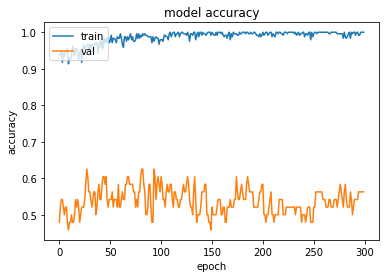

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



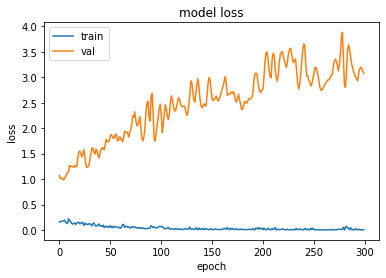

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

